# Importamos librerías

In [13]:
import cv2 # OpenCV

import time

# Mostrar imágenes embedidas en jupyter
import IPython.display
from IPython.display import clear_output
import PIL.Image
from io import BytesIO

# Numpy
import numpy as np

# Non Max Supression
import imutils
from imutils.object_detection import non_max_suppression

# Funciones de ayuda

In [2]:
#Usa 'jpeg' en vez de 'png' (~5 veces más rápido)
def array_to_image(a, fmt='jpeg'):
    # Creamos un flujo de datos binario
    f = BytesIO()
    
    # Convertimos el arreglo a un objeto de flujos binarios
    PIL.Image.fromarray(a).save(f, fmt)
    
    return IPython.display.Image(data=f.getvalue())

In [3]:
def get_frame(cam, size=None, is_camera=True):
    # Capturar fotograma por fotograma
    ret, frame = cam.read()
    
    if size:
        if isinstance(size, tuple):
            frame = cv2.resize(frame, size)
        elif isinstance(size, float) or isinstance(int, size):
            h, w, _ = frame.shape
            frame = cv2.resize(frame, (int(w*size), int(h*size)))
    
    if is_camera:
        # Espejado de la imágen
        frame = cv2.flip(frame, 1)
    
    return frame

# Haar Cascade

## Filtros
<img src="imgs/viola_jhones_1.png" alt="Drawing" style="width: 600px;"/>

## Cascade
<img src="imgs/viola_jhones_3.png" alt="Drawing" style="width: 600px;"/>

## Features

<img src="imgs/viola_jhones_5.png" alt="Drawing" style="width: 600px;"/>

$$\tiny\Delta = \frac{1}{n} \sum_{dark}^{n} I(x) - \frac{1}{n} \sum_{white}^{n} I(x)$$
$$\tiny(0.1+0.2+0.2+0.3+0.2+0.1+0.2+0.1)/8 = 0.18 \text{ White}$$
$$\tiny(0.6+0.8+0.8+0.6+0.6+0.8+0.8+0.9)/8 = 0.74 \text{ Dark}$$

$$\tiny\Delta = 0.74 - 0.18 = 0.56$$

Queremos que el valor de delta sea lo más cercano a 1

## Imágen integral

<img src="imgs/viola_jhones_2.png" alt="Drawing" style="width: 600px;"/>

<img src="imgs/viola_jhones_6.png" alt="Drawing" style="height: 300px; width: 200"/>

In [4]:
person_cascade = cv2.CascadeClassifier('cascades/OpenCVcascades/cascades/haarcascade_fullbody.xml')

cam = cv2.VideoCapture('TownCentreXVID.avi')

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
while True:
    try:
        t1 = time.time()
#         frame = get_frame(cam, size=0.6, is_camera=False, )
        frame = get_frame(cam, size=(640, 360), is_camera=False, )
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        ## WORK HERE ##
        boxes = person_cascade.detectMultiScale(gray_frame)
        
        # Non Max Supression
        rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])
        cleaned_boxes = non_max_suppression(rects, probs=None, overlapThresh=0.8)
        
        for x1, y1, x2, y2 in cleaned_boxes:
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        ###############
        
        im = array_to_image(frame)
        
        d.update(im)
        
        t2 = time.time()
        
        s = f"""{int(1/(t2-t1))} FPS"""
        d2.update( IPython.display.HTML(s) )
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped


# HOG

In [5]:
from skimage.feature import hog
from skimage import data, exposure

import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = [20, 10]

### Calculamos el HOG de una imágen

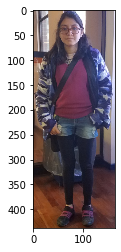

In [6]:
larisa = cv2.cvtColor(cv2.imread('larisa_recortada.png'), cv2.COLOR_BGR2RGB)
h, w, _ = larisa.shape
larisa = cv2.resize(larisa, (w//2, h//2))

plt.imshow(larisa)
plt.show()

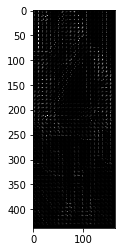

In [7]:
_, hog_image = hog(larisa, orientations=8, pixels_per_cell=(8, 8),
                    cells_per_block=(1, 1), visualize=True, multichannel=True)

plt.imshow(hog_image, cmap='gray')
plt.show()

In [8]:
person_hog = cv2.HOGDescriptor()
person_hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

cam = cv2.VideoCapture('TownCentreXVID.avi')

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
while True:
    try:
        t1 = time.time()
#         frame = get_frame(cam, size=0.6, is_camera=False, )
        frame = get_frame(cam, size=(1280, 720), is_camera=False, )
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        ## WORK HERE ##
        boxes, weights = person_hog.detectMultiScale(gray_frame)
        
        # Non Max Supression
        rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in boxes])
        cleaned_boxes = non_max_suppression(rects, probs=None, overlapThresh=0.65)
        
        for (x1, y1, x2, y2), weight in zip(cleaned_boxes, weights):
            if weight > 0.5:
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        ###############
        
        im = array_to_image(frame)
        
        d.update(im)
        
        t2 = time.time()
        
        s = f"""{int(1/(t2-t1))} FPS"""
        d2.update( IPython.display.HTML(s) )
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped


# YOLO (You only look once)

![alt-text](imgs/conv.gif)

<img src="imgs/cnn.png" alt="Drawing" style="width: 700px;"/>

<img src="imgs/yolo.jpg" alt="Drawing" style="width: 700px; align: center"/>

# Importando la librería

In [9]:
from pydarknet import Detector, Image

In [10]:
net = Detector(bytes("data/yolov3.cfg", encoding="utf-8"),
               bytes("data/yolov3.weights", encoding="utf-8"),
               0,
               bytes("data/coco.data", encoding="utf-8"))

In [11]:
cam = cv2.VideoCapture('TownCentreXVID.avi')

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
while True:
    try:
        t1 = time.time()
#         frame = get_frame(cam, size=0.6, is_camera=False, )
        frame = get_frame(cam, size=(640, 360), is_camera=False)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        
        ## WORK HERE ##
        predictions: dict = net.detect(Image(frame))
        
        for object_class, confidence, (x, y, w, h) in predictions:
            if object_class.decode('utf-8') == 'person' and confidence > 0.5:
                x1, y1, x2, y2 = int(x - w / 2), int(y - h / 2), int(x + w / 2), int(y + h / 2)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        ###############
        
        im = array_to_image(frame)
        
        d.update(im)
        
        t2 = time.time()
        
        s = f"""{int(1/(t2-t1))} FPS"""
        d2.update( IPython.display.HTML(s) )
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped


# Webcam

In [14]:
face_cascade = cv2.CascadeClassifier('cascades/OpenCVcascades/cascades/haarcascade_frontalface_default.xml')

cam = cv2.VideoCapture(0)

d = IPython.display.display("", display_id=1)
d2 = IPython.display.display("", display_id=2)
while True:
    try:
        t1 = time.time()
        frame = get_frame(cam)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        ## WORK HERE ##
        boxes = face_cascade.detectMultiScale(gray_frame)
        
        for x, y, w, h in boxes:
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        predictions: dict = net.detect(Image(frame))
        
        for object_class, confidence, (x, y, w, h) in predictions:
            if object_class.decode('utf-8') == 'person' and confidence > 0.5:
                x1, y1, x2, y2 = int(x - w / 2), int(y - h / 2), int(x + w / 2), int(y + h / 2)
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
        ###############
        
        im = array_to_image(frame)
        
        d.update(im)
        
        t2 = time.time()
        
        s = f"""{int(1/(t2-t1))} FPS"""
        d2.update( IPython.display.HTML(s) )
    except KeyboardInterrupt:
        print()
        cam.release()
        IPython.display.clear_output()
        print ("Stream stopped")
        break

Stream stopped
